In [1]:
import os
os.environ["DGLBACKEND"] = "pytorch"
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np

### Utiity functions

In [2]:
from dgl.sparse import spmatrix

def adj_mat_with_edge_prop(m, etype= None, eprop=None):
    
    
    etype = m.to_canonical_etype(etype)
    indices = torch.stack(m.all_edges(etype=etype))
    shape = (m.num_nodes(etype[0]), m.number_of_nodes(etype[2]))
    if eprop is not None:
        val = m.edges[etype].data[eprop].flatten()
    else:
        val = None
        
    return spmatrix(
        indices,
        val=val,
        shape=shape,
    )

In [3]:
import matplotlib.pyplot as plt

import networkx as nx
def plot_net(net,options = None):
    netG = dgl.to_networkx(net)
    plt.figure(figsize=[15,7])
    if options != None:
        nx.draw(netG,**options)
    else:
        nx.draw(netG)

In [4]:
def triu(spm):
    mask = spm.row <= spm.col
    return dgl.sparse.from_coo(spm.row[mask],spm.col[mask],spm.val[mask],shape=spm.shape)

In [5]:
def sym_from_triu(triuspm):
    return triuspm + triuspm.T

In [6]:
def sparse_from_mask(om, mask):
    return dgl.sparse.from_coo(om.row[mask],om.col[mask],om.val[mask],shape=om.shape)

### Load data

In [7]:
ds = dgl.data.CSVDataset('./toy_dataset/toy_local_attach')

Done loading data from cached files.


In [8]:
g = ds[0]

In [9]:
g.edata['w'] = torch.rand(g.num_edges(),1)

### Visualize graph

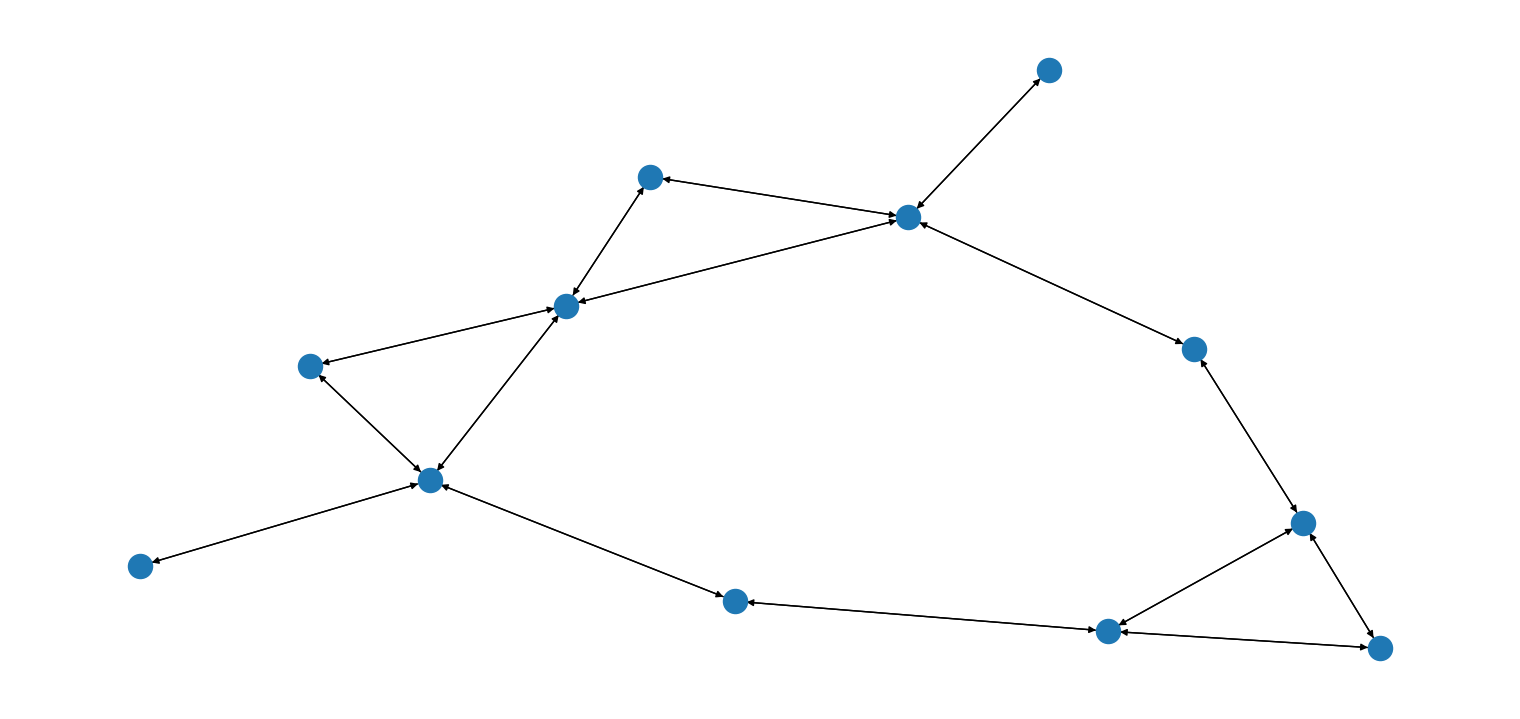

In [10]:
plot_net(g)

### Get adjacency matrix with edge data (weigths)
in the case of the toy model used here the weights must first be symmetrized. In a real application this matrix would already be symmetrical.

In [11]:
adje = adj_mat_with_edge_prop(g, eprop='w')

In [12]:
sadje = sym_from_triu(triu(adje))

#### This constitutes the symmetrical adjacency matrix with edge weights

In [13]:
sadje

SparseMatrix(indices=tensor([[ 0,  0,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,  5,  5,  6,  6,  6,
                               6,  7,  7,  7,  8,  9,  9, 10, 10, 10, 11, 11],
                             [ 2,  6,  2,  0,  1,  3,  6,  2,  7,  5,  6,  8,  9,  4,  6,  0,  2,  4,
                               5,  3, 10, 11,  4,  4, 10,  7,  9, 11,  7, 10]]),
             values=tensor([0.7047, 0.1995, 0.7434, 0.7047, 0.7434, 0.6952, 0.8666, 0.6952, 0.5964,
                            0.3464, 0.9884, 0.4055, 0.5695, 0.3464, 0.7105, 0.1995, 0.8666, 0.9884,
                            0.7105, 0.5964, 0.9261, 0.7262, 0.4055, 0.5695, 0.7649, 0.9261, 0.7649,
                            0.8038, 0.7262, 0.8038]),
             shape=(12, 12), nnz=30)

#### Next, we renormalize the weights
this follows the example in PovertyTrap but that omes at a cost, with increasing size the normalization summ will increase, making unscales randoom sampling more difficult (i.e. the normalzed weights decrease). his is handled by rescling wih a coonstant factor here, but deserves a better solution

In [14]:
norm_weights = sadje.val/sadje.val.sum()

In [15]:
norm_weights.shape

torch.Size([30])

In [16]:
sadjenorm = dgl.sparse.from_coo(sadje.row,sadje.col,norm_weights,shape=sadje.shape)

In [17]:
sadjenorm

SparseMatrix(indices=tensor([[ 0,  0,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,  5,  5,  6,  6,  6,
                               6,  7,  7,  7,  8,  9,  9, 10, 10, 10, 11, 11],
                             [ 2,  6,  2,  0,  1,  3,  6,  2,  7,  5,  6,  8,  9,  4,  6,  0,  2,  4,
                               5,  3, 10, 11,  4,  4, 10,  7,  9, 11,  7, 10]]),
             values=tensor([0.0351, 0.0099, 0.0370, 0.0351, 0.0370, 0.0346, 0.0431, 0.0346, 0.0297,
                            0.0172, 0.0492, 0.0202, 0.0283, 0.0172, 0.0354, 0.0099, 0.0431, 0.0492,
                            0.0354, 0.0297, 0.0461, 0.0361, 0.0202, 0.0283, 0.0381, 0.0461, 0.0381,
                            0.0400, 0.0361, 0.0400]),
             shape=(12, 12), nnz=30)

### Select node pairs (src, dst) as elements of the matrix 

An element (i,j) of the adjacency matrix represents an edge between the nodes i (src) and j (dst). A selection based on the weights of their connections can therefore be realized by drawing using a random seletion field applied to the adjacency matrix.

NOTE: ALthough the weights of the adjacency matrix are symmetrical, because we assume a bi-directional edge between nodes, for this selection process the distinction between src and dst node is relevant, and we make use of the full matrix

In [18]:
selfield = torch.rand(sadjenorm.val.size()[0])/50. #scale by 1/50

##### Apply random field as mask selecting edges on weight

In [19]:
selmask = sadjenorm.val > selfield

In [20]:
selmask

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

### Create a sparse matrix with ONLY the selected links

Note: This matrix does not need to be symmetrical, as the selection also reflects the definition of which nide is considerd the src node and which the dst node for the purpose of identifying neighbours

In [21]:
sadjenormsel = sparse_from_mask(sadjenorm,selmask)

In [22]:
sadjenormsel

SparseMatrix(indices=tensor([[ 0,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,  5,  5,  6,  6,  6,  7,
                               7,  7,  8,  9,  9, 10, 10, 10, 11, 11],
                             [ 2,  2,  0,  1,  3,  6,  2,  7,  5,  6,  8,  9,  4,  6,  2,  4,  5,  3,
                              10, 11,  4,  4, 10,  7,  9, 11,  7, 10]]),
             values=tensor([0.0351, 0.0370, 0.0351, 0.0370, 0.0346, 0.0431, 0.0346, 0.0297, 0.0172,
                            0.0492, 0.0202, 0.0283, 0.0172, 0.0354, 0.0431, 0.0492, 0.0354, 0.0297,
                            0.0461, 0.0361, 0.0202, 0.0283, 0.0381, 0.0461, 0.0381, 0.0400, 0.0361,
                            0.0400]),
             shape=(12, 12), nnz=28)

In [23]:
sadjenormsel.to_dense()

tensor([[0.0000, 0.0000, 0.0351, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0370, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0351, 0.0370, 0.0000, 0.0346, 0.0000, 0.0000, 0.0431, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0346, 0.0000, 0.0000, 0.0000, 0.0000, 0.0297, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0172, 0.0492, 0.0000, 0.0202,
         0.0283, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0172, 0.0000, 0.0354, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0431, 0.0000, 0.0492, 0.0354, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0297, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0461, 0.0361],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0202, 0.0000, 0.0000, 0.0000, 0.0000,

In [24]:
def construct_neighbour_fields(selm,adjm):
    """
    This fucnction creates the row tensor, column tensor, link tensor, and value tensor
    needed to construct the neighbour field matrix/tensor in sparse representation. This is done by creating a list of the tensor
    representations for each element i,j of the matrix of selected edges by adding row i and row j of the adjacency
    matrix, and storing the result in row i, for each element an insttance of row i as well as the entry i,i is removed. The list is subsequently concatenated to obtain a single tensor representation.
    In addition to the link tensor, which denotes the link status with and integer, the function also returns a value tensor with
    with entries corresponding to the weight of edge j,k. neighbours wiith no direct connecton appear as > 0 values
    
    The resulting tensors can/will contain significant numbers of multiple assigments for an element i,k. This is addressed in
    subsequent processing. This also handles the combinattion of weights for elligible connections arising from multiple possible links 
    
    Input:
    
    :param: selm matrix of selected edges in sparse format (dgl.sparse.spmatrix)
    :param: adjm adjacency matrix witth edge weights as sparse values
    
    Output:
    
    :param: rowtensor (row tensor of the neighbour field matrix, compattible with sparse format)
    :param: coltensor (column tensor of the neighbour field matrix, compatible with sparse format)
    :param: ltensor (link tensor of the neighbouir field matrix, compatible with sparse format) 
    :param: valtensor (tensor with edge weights of link jk)
    
    """
    rtl = list()
    ctl = list()
    ltl = list()
    vtl = list()
    for i in range(selm.row.shape[0]):
        src = selm.row[i]
        dst = selm.col[i]
        srcten = torch.tensor([src])
        wsrcten = torch.tensor([0.])
        lsrcten = torch.tensor([-1])
        src_nids = adjm.col[adjm.row==src]
        wsrc_nids = adjm.val[adjm.row==src]
        lsrc_nids = torch.ones_like(src_nids,dtype=int)*(-1)
        dst_nids = adjm.col[adjm.row==dst]
        wdst_nids = adjm.val[adjm.row==dst]
        ldst_nids = torch.ones_like(dst_nids,dtype=int)
        rv_src_nids = torch.ones_like(src_nids)*src
        rv_dst_nids = torch.ones_like(dst_nids)*src
        rv_nids = torch.cat((rv_src_nids,rv_dst_nids,srcten))
        cv_nids = torch.cat((src_nids,dst_nids,srcten))
        lv_nids = torch.cat((lsrc_nids,ldst_nids,lsrcten))
        wv_nids = torch.cat((wsrc_nids,wdst_nids,wsrcten))
        rtl.append(rv_nids)
        ctl.append(cv_nids)
        ltl.append(lv_nids)
        vtl.append(wv_nids)
        
        
        
     
    rowtensor = torch.cat(rtl)
    coltensor = torch.cat(ctl)
    ltensor   = torch.cat(ltl)
    valtensor = torch.cat(vtl)
    
    return (rowtensor, coltensor, ltensor, valtensor)

In [25]:
nf = construct_neighbour_fields(sadjenormsel,sadjenorm)

In [26]:
nf

(tensor([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
          8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]),
 tensor([ 2,  6,  0,  1,  3,  6,  0,  2,  0,  1,  3,  6,  1,  0,  1,  3,  6,  2,
          6,  2,  0,  1,  3,  6,  2,  2,  0,  1,  

Construct sparse matriix representations of the neighbour fields based on the link tensor (for identifying potential new links) and the value tensor (for propagating the edge weights)

In [27]:
indices= torch.stack((nf[0],nf[1])) #stack indices into tensor for matrix construction
nfm = dgl.sparse.spmatrix(indices,nf[2],shape=sadjenormsel.shape) # create link neighbour fields
nfmv = dgl.sparse.spmatrix(indices,nf[3],shape=sadjenormsel.shape) # create value neighbour fields


### dealing with multiple assgnments

As a result of their construction the tensors reppresenting the sparse neighbour field matrix can/will contain multiple assigments to the same eement. While this is not a problem for the matrix representation perse, these should be combined before matrix arithmetic opertations are be performed. This can be done using the `.coalesce()` method, which sums all assigments to a single matrix element.

In [28]:
nfmc =nfm.coalesce()
nfmvc = nfmv.coalesce()

In [29]:
nfmc.to_dense()

tensor([[ 0,  1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0, -1,  1,  0,  0,  1,  0,  0,  0,  0,  0],
        [-3, -4,  0, -4,  1,  1, -3,  1,  0,  0,  0,  0],
        [ 1,  1, -2,  0,  0,  0,  1, -2,  0,  0,  1,  1],
        [ 1,  0,  1,  0,  0, -3, -3,  0, -4, -4,  1,  0],
        [ 1,  0,  1,  0, -1,  0, -1,  0,  1,  1,  0,  0],
        [-2,  1, -3,  1, -2, -2,  0,  0,  1,  1,  0,  0],
        [ 0,  0,  1, -3,  0,  0,  0,  0,  0,  1, -2, -2],
        [ 0,  0,  0,  0, -1,  1,  1,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0, -2,  1,  1,  1,  1,  0, -2,  1],
        [ 0,  0,  0,  1,  1,  0,  0, -2,  0, -3,  0, -2],
        [ 0,  0,  0,  1,  0,  0,  0, -1,  0,  1, -1,  0]])

In [30]:
nfmvc.to_dense()


tensor([[0.0351, 0.0370, 0.0351, 0.0346, 0.0000, 0.0000, 0.0531, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0351, 0.0370, 0.0370, 0.0346, 0.0000, 0.0000, 0.0431, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.1502, 0.1480, 0.1498, 0.1384, 0.0492, 0.0354, 0.1824, 0.0297, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0351, 0.0370, 0.0692, 0.0643, 0.0000, 0.0000, 0.0431, 0.0594, 0.0000,
         0.0000, 0.0461, 0.0361],
        [0.0099, 0.0000, 0.0431, 0.0000, 0.1149, 0.1043, 0.2321, 0.0000, 0.0807,
         0.1134, 0.0381, 0.0000],
        [0.0099, 0.0000, 0.0431, 0.0000, 0.0837, 0.0526, 0.1199, 0.0000, 0.0202,
         0.0283, 0.0000, 0.0000],
        [0.0649, 0.0370, 0.1294, 0.0346, 0.1648, 0.1233, 0.1277, 0.0000, 0.0202,
         0.0283, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0346, 0.0890, 0.0000, 0.0000, 0.0000, 0.1119, 0.0000,
         0.0381, 0.1783, 0.1484],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0202, 0.0172, 0.0492, 0.0000, 0.0202,

### Identify potential links
with the neighbourr fields at hand we create a matrix representattio of all potential links by adding the 1-values adjacency matrix and the link neighbour field matrix `nfmc` 

In [31]:
possible_links_mask = nfmc.val > 0

In [32]:
nfmc.val[possible_links_mask]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
possible_links_matrix = sparse_from_mask(nfmc,possible_links_mask)

In [34]:
possible_links_weights = sparse_from_mask(nfmvc,possible_links_mask)

In [35]:
possible_links_weights.to_dense()

tensor([[0.0000, 0.0370, 0.0000, 0.0346, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0351, 0.0000, 0.0000, 0.0346, 0.0000, 0.0000, 0.0431, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0492, 0.0354, 0.0000, 0.0297, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0351, 0.0370, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431, 0.0000, 0.0000,
         0.0000, 0.0461, 0.0361],
        [0.0099, 0.0000, 0.0431, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0381, 0.0000],
        [0.0099, 0.0000, 0.0431, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0202,
         0.0283, 0.0000, 0.0000],
        [0.0000, 0.0370, 0.0000, 0.0346, 0.0000, 0.0000, 0.0000, 0.0000, 0.0202,
         0.0283, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0346, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0381, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0172, 0.0492, 0.0000, 0.0000,

In [36]:
possible_links_matrix.to_dense()

tensor([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

### Selecting non-mutual links based on edge weight
From the representation of all potential new links we can randomly select those to be created based on edge weight

In [37]:
link_selection = torch.rand(possible_links_weights.val.size()[0])

In [38]:
selected_link_mask = possible_links_weights.val > link_selection/50 

In [39]:
selected_link_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True])

Using this mask we obtain tensors of src, dst node ids for the links to be created.

Visualize graph before adding edges

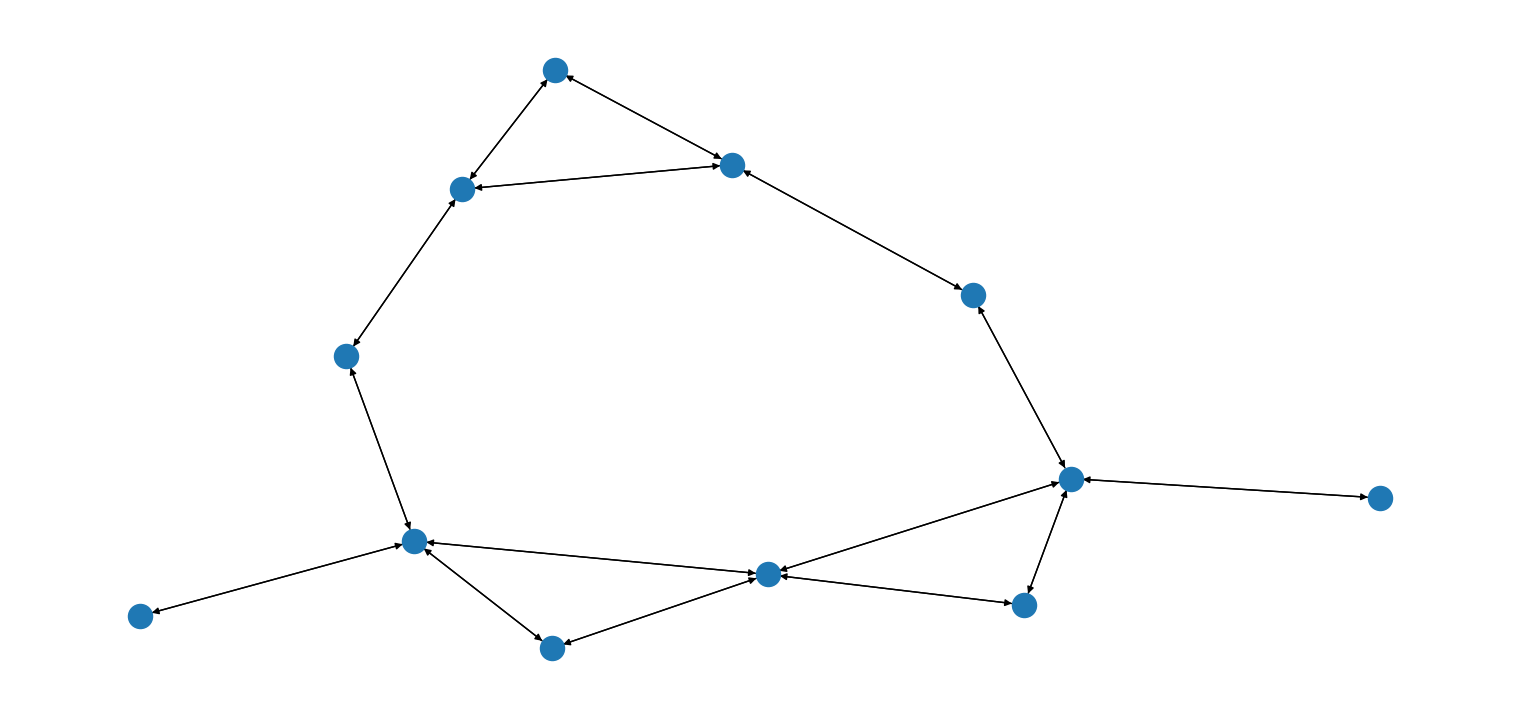

In [40]:
plot_net(g)

In [41]:
g.add_edges(possible_links_weights.row[selected_link_mask],possible_links_weights.col[selected_link_mask])

add reverse edges by inverting src and dst (row and column)

In [42]:

g.add_edges(possible_links_weights.col[selected_link_mask],possible_links_weights.row[selected_link_mask])

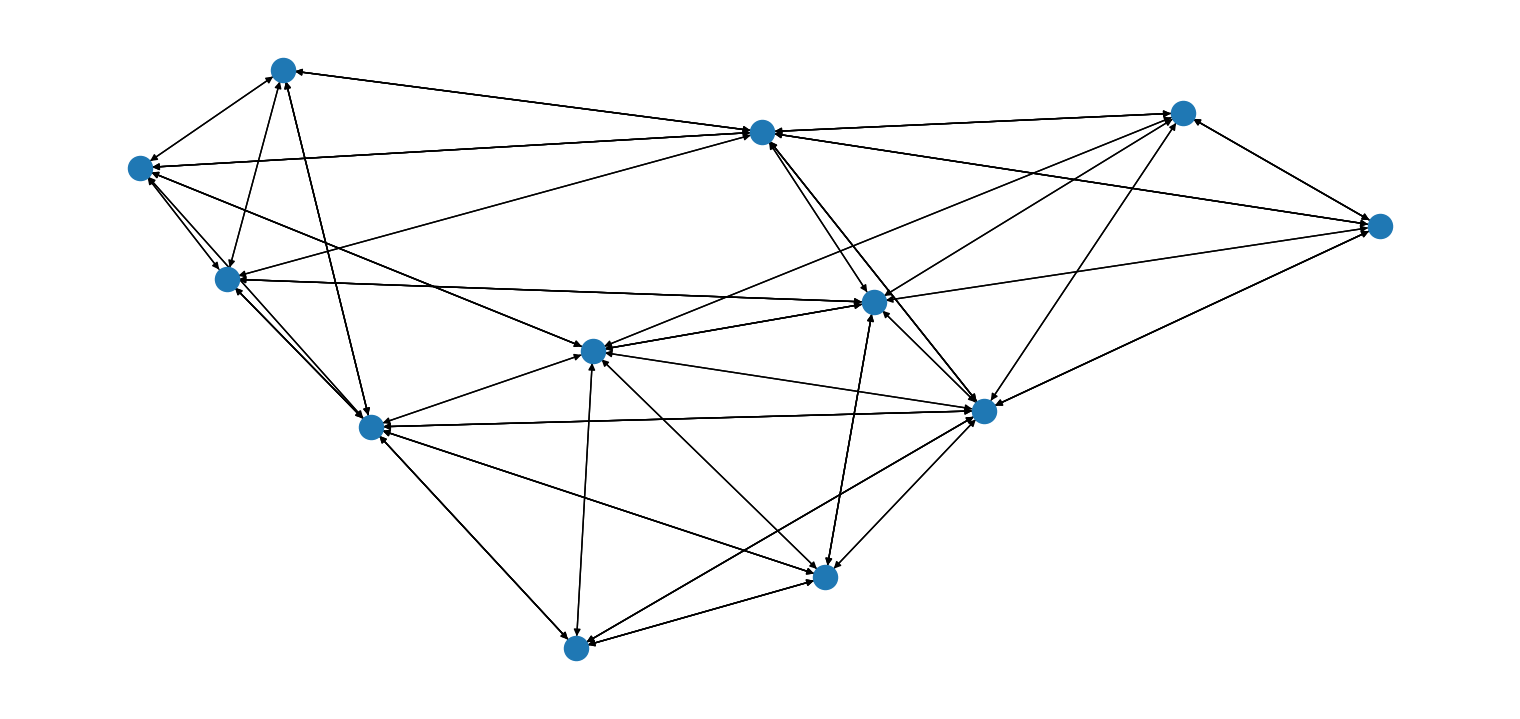

In [43]:
plot_net(g)